<a href="https://colab.research.google.com/github/ishara-bangkit-capstone-project/ishara-machine-learning/blob/main/MobileNetV2_RMSProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data from Kaggle to further processing it

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d agungmrf/indonesian-sign-language-bisindo

Dataset URL: https://www.kaggle.com/datasets/agungmrf/indonesian-sign-language-bisindo
License(s): unknown
100% 1.36G/1.36G [00:11<00:00, 86.3MB/s]
100% 1.36G/1.36G [00:11<00:00, 126MB/s] 


#Importing the necessary Library


In [ ]:
# Import library yang diperlukan
import tensorflow as tf
import zipfile,os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os
import zipfile
import shutil
import cv2
import pandas as pd
import shutil
from tqdm.notebook import tqdm as tq
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Exctracting the Picture Data from kaggle


In [ ]:
# Tentukan nama file ZIP dan direktori ekstraksi
local_zip = '/content/indonesian-sign-language-bisindo.zip'
extract_dir = '/content/bisindo'

# Ekstrak file ZIP
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [ ]:
# Menghapus directory labels, karena yang dipakai hanya directory images
shutil.rmtree('/content/bisindo/bisindo/labels/')

In [ ]:
# Unpacking the the extracting data and putting it in list
data_dir = '/content/bisindo'

images = []
labels = []
label = []
for path, subdirs, files in os.walk(data_dir):
    for name in files:
        label.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        images.append(name)

#Using DataFrame Object to Preprocessing the data from list to Tabular Data Format


In [ ]:
# Using DataFrame Object to Preprocessing the data from list to Tabular Data Format
df = pd.DataFrame({"path":label,'file_name':images,"tag":labels})
df

,path,file_name,tag
0,/content/bisindo/bisindo/images/train/J/augmen...,augmented_image_69.jpg,J
1,/content/bisindo/bisindo/images/train/J/body d...,body dot (2).jpg,J
2,/content/bisindo/bisindo/images/train/J/augmen...,augmented_image_50.jpg,J
3,/content/bisindo/bisindo/images/train/J/flip07...,flip078.jpg,J
4,/content/bisindo/bisindo/images/train/J/rotate...,rotate097.jpg,J
...,...,...,...
11465,/content/bisindo/bisindo/images/val/M/flip055.jpg,flip055.jpg,M
11466,/content/bisindo/bisindo/images/val/M/wall whi...,wall white (2).jpg,M
11467,/content/bisindo/bisindo/images/val/M/augmente...,augmented_image_24.jpg,M
11468,/content/bisindo/bisindo/images/val/M/rotate09...,rotate090.jpg,M


In [ ]:
# Checking the Distribution of Data from Tag
df.groupby(['tag']).size()

tag
A    438
B    439
C    429
D    435
E    441
F    447
G    450
H    435
I    450
J    450
K    435
L    447
M    444
N    438
O    447
P    447
Q    435
R    438
S    429
T    450
U    444
V    447
W    450
X    444
Y    411
Z    450
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11470 entries, 0 to 11469
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       11470 non-null  object
 1   file_name  11470 non-null  object
 2   tag        11470 non-null  object
dtypes: object(3)
memory usage: 269.0+ KB


In [ ]:
# Tentukan ukuran gambar yang diinginkan
width = 100
height = 100

# Resize gambar
resized_images = [cv2.resize(cv2.imread(img_path), (width, height)) for img_path in df['path']]


In [ ]:
# Normalisasi
normalized_images = [img / 255.0 for img in resized_images]

In [ ]:
df

,path,file_name,tag
0,/content/bisindo/bisindo/images/train/J/augmen...,augmented_image_69.jpg,J
1,/content/bisindo/bisindo/images/train/J/body d...,body dot (2).jpg,J
2,/content/bisindo/bisindo/images/train/J/augmen...,augmented_image_50.jpg,J
3,/content/bisindo/bisindo/images/train/J/flip07...,flip078.jpg,J
4,/content/bisindo/bisindo/images/train/J/rotate...,rotate097.jpg,J
...,...,...,...
11465,/content/bisindo/bisindo/images/val/M/flip055.jpg,flip055.jpg,M
11466,/content/bisindo/bisindo/images/val/M/wall whi...,wall white (2).jpg,M
11467,/content/bisindo/bisindo/images/val/M/augmente...,augmented_image_24.jpg,M
11468,/content/bisindo/bisindo/images/val/M/rotate09...,rotate090.jpg,M


# Splitting the data Training, Validation, Test Data

In [ ]:
X= df['path']
y= df['tag']

# Split dataset to become training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

# Test dataset divided equally
X_test, X_val, y_test, y_val_a= train_test_split(
    X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
# Checking the result of Splitting data
df_train = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_test = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val_a
             ,'set':'validation'})

print('train size', len(df_train))
print('val size', len(df_test))
print('test size', len(df_val))

train size 8029
val size 1720
test size 1721


In [ ]:
# Gabungkan DataFrame df_train, df_test, dan df_val menjadi df_all
df_all = pd.concat([df_train, df_test, df_val]).reset_index(drop=True)

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

# Cek sampel data
df_all.sample(3)



set         tag
test        A      77
            B      64
            C      68
            D      67
            E      60
                   ..
validation  V      67
            W      76
            X      62
            Y      54
            Z      69
Length: 78, dtype: int64 




,path,tag,set
9354,/content/bisindo/bisindo/images/train/I/flip04...,I,test
8210,/content/bisindo/bisindo/images/train/Z/rotate...,Z,test
7806,/content/bisindo/bisindo/images/train/A/flip02...,A,train


#Creating the Folder Dataset for Training, Validation, Test Data

In [ ]:
dataset_path = "content/dataset/"
for index, row in tq(df_all.iterrows()):

    # detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(data_dir,row['tag'],row['image'].split('.')[0])

    # make folder destination dirs
    if os.path.exists(os.path.join(data_dir,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(data_dir,row['set'],row['tag']))

    # define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(data_dir,row['set'],row['tag'],destination_file_name)

    # copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
train_data_dir = '/content/bisindo/train'
validation_data_dir = '/content/bisindo/validation'
test_data_dir = '/content/bisindo/test'

batch_size = 512
num_classes = 26

# Define data generators
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   rotation_range=25,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Loading data with tensorflow
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8029 images belonging to 26 classes.
Found 1721 images belonging to 26 classes.
Found 1720 images belonging to 26 classes.


# TRAINING

## Using Transfer Learning Method, MobileNetV2 and fine-tuning it

In [ ]:
# Load MobileNetV2 without the top classification layer
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of MobileNetV2
modelmn2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Adjust to the correct number of classes
])

# Compile the model
modelmn2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005), loss='categorical_crossentropy',metrics=['accuracy'])

# Display model summary
modelmn2.summary()

# Training parameters
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
epochs = 10

# Train the model
history = modelmn2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 26)                26650     
                                                           

# Checking the Loss and Accuracy visualization of the resulted Training

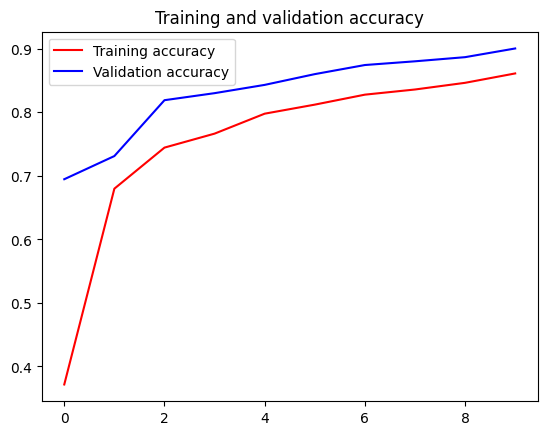

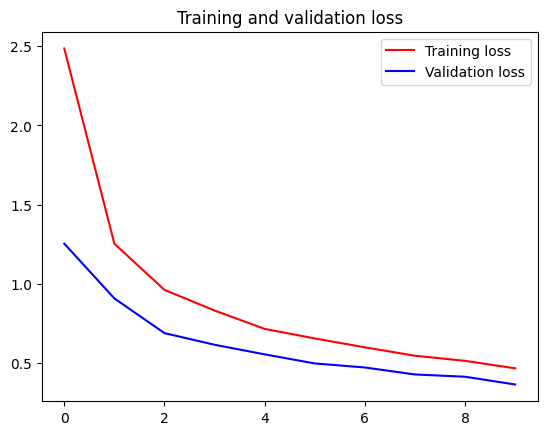

In [ ]:
history = modelmn2.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig('MobileVnet2-percobaan_accuracy3.png')
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.savefig('MobileVnet2-percobaan_loss3.png')
plt.show()


In [ ]:
loss, acc = modelmn2.evaluate(train_generator,steps=len(train_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')

loss, acc = modelmn2.evaluate(test_generator,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

Accuracy on training data: 0.8959 
Loss on training data: 0.3647 

Accuracy on test data: 0.8994 
Loss on test data: 0.3364 



#Saving the data

In [ ]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "medium_project"
SAVE_MODEL_NAME = "model-percobaan2-MobileNetV2.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
modelmn2.save(save_model_path,include_optimizer=False)

Saving Model At model/medium_project/model-percobaan2-MobileNetV2.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
